<a href="https://colab.research.google.com/github/flor-g/Undergraduate-thesis/blob/main/Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def solve_rsa_threshold(alpha=1.0, cost_all=0.0):
    """
    Determines the prior probability P(m_all) threshold at which the
    interpretation of 'some' flips from 'some-but-not-all' to 'all'.
    """

    # We iterate through possible Prior values for m_all (0.01 to 0.99)
    priors_all = np.linspace(0.001, 0.999, 1000)

    threshold = None

    for p_all in priors_all:
        p_sna = 1.0 - p_all  # Probability of Some-But-Not-All

        # --- 1. Literal Listener L0 (Uniform Prior) ---
        # We assume 2 states: [SNA, ALL]
        # Utterance 'some' is compatible with both {SNA, ALL}
        # Utterance 'all' is compatible only with {ALL}

        # L0(m | u='some') -> Uniform distribution over compatible states
        l0_some_given_all = 0.5
        l0_some_given_sna = 0.5

        # L0(m | u='all') -> 1.0 on ALL (0 on SNA)
        l0_all_given_all = 1.0

        # --- 2. Pragmatic Speaker S1 ---
        # Utility = ln(L0(m|u)) - cost

        # Scenario A: Speaker wants to communicate m_ALL
        # Option 1: Say 'some'
        # Utility = ln(0.5) ≈ -0.69
        u_some_given_all = np.log(l0_some_given_all)

        # Option 2: Say 'all'
        # Utility = ln(1.0) - cost = 0 - cost
        u_all_given_all = np.log(l0_all_given_all) - cost_all

        # Softmax: Calculate probability S1 chooses 'some' given state is ALL
        # P(u_some | m_all) \propto exp(alpha * Utility)
        score_some = np.exp(alpha * u_some_given_all)
        score_all = np.exp(alpha * u_all_given_all)
        s1_some_given_all = score_some / (score_some + score_all)

        # Scenario B: Speaker wants to communicate m_SNA
        # Must say 'some' (assuming 'all' is false/impossible)
        s1_some_given_sna = 1.0

        # --- 3. Pragmatic Listener L1 ---
        # Bayes Rule: P(m | u) \propto S1(u | m) * P(m)

        # Evidence for ALL comes from the Speaker's likelihood * Prior
        posterior_unnorm_all = s1_some_given_all * p_all

        # Evidence for SNA comes from Speaker's likelihood * Prior
        posterior_unnorm_sna = s1_some_given_sna * p_sna

        # Normalize
        prob_all_given_some = posterior_unnorm_all / (posterior_unnorm_all + posterior_unnorm_sna)

        # --- 4. Check Threshold ---
        # Does the "non-scalar" reading (m_all) prevail?
        if prob_all_given_some > 0.5:
            threshold = p_all
            break

    return threshold

# --- Run the Model ---
alphas = [1.0, 2.0, 3.0, 4.0]
print(f"{'Alpha':<10} | {'Threshold P(m_all)':<20}")
print("-" * 35)

for a in alphas:
    t = solve_rsa_threshold(alpha=a)
    print(f"{a:<10} | {t:.4f}")

Alpha      | Threshold P(m_all)  
-----------------------------------
1.0        | 0.7502
2.0        | 0.8342
3.0        | 0.9001
4.0        | 0.9451


L2 Threshold found: P(m_all) > 0.9594


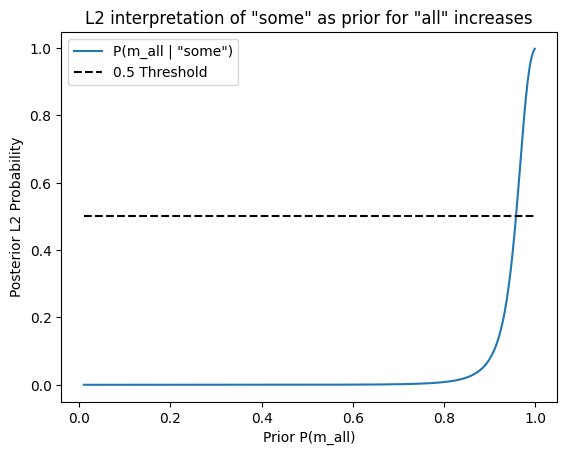

In [7]:
import matplotlib.pyplot as plt

def solve_rsa_l2_threshold(total_marbles=10, alpha=1.0, cost_null=1.0):
    """
    Finds the prior threshold P(m_all) where the L2 listener's interpretation
    of 'some' flips from 'some-but-not-all' to 'all'.
    """

    states = np.arange(total_marbles + 1) # 0, 1, ..., 10

    # --- semantics ---
    # Rows = States (0..10), Cols = Utterances [some, all, null]
    # some: true for states 1..10
    # all: true for state 10
    # null: true for states 0..10 (always true)
    vocab = ['some', 'all', 'null']
    semantics = np.zeros((len(states), len(vocab)))

    semantics[1:, 0] = 1.0  # 'some' is true for 1..10
    semantics[10, 1] = 1.0  # 'all' is true for 10
    semantics[:, 2] = 1.0   # 'null' is true for 0..10

    costs = np.array([0.0, 0.0, cost_null]) # Costs for [some, all, null]

    # Iterate p_all from 0.01 to 0.99
    priors_range = np.linspace(0.01, 0.999, 500)
    threshold = None

    # Store L2 probabilities for visualization
    prob_all_trace = []

    for p_all in priors_range:
        # Construct Prior P(m)
        # We assign p_all to state 10.
        # We distribute the remaining (1 - p_all) uniformly among 0..9
        p_other_total = 1.0 - p_all
        prior = np.full(len(states), p_other_total / 10.0) # 0..9 get uniform share
        prior[10] = p_all

        # === RECURSION ===

        # 1. Literal Listener L0
        # P(m | u) = Prior(m) * Semantics(m, u) / Normalizer
        # Note: Standard RSA often uses a uniform prior for L0 to capture literal truth first,
        # but advanced models (like S2/L2) often thread the 'true' prior through.
        # However, to see 'implicature' effects driven by priors, L0 is usually uniform or
        # the prior is applied at L1.
        # We will apply the ACTUAL WORLD PRIOR at the Listener steps (L1, L2).
        # We will use a UNIFORM prior for L0 to represent pure semantic decoding.

        prior_uniform = np.ones(len(states)) / len(states)
        l0_unnorm = semantics * prior_uniform[:, None] # (states, utterances)
        l0 = l0_unnorm / l0_unnorm.sum(axis=0, keepdims=True)

        # 2. Speaker S1
        # U(u | m) = ln(L0(m|u)) - cost
        # P(u | m) \propto exp(alpha * U)

        # l0 has shape (states, utterances). We want L0(m|u) for each cell.
        # Transpose for easier broadcasting: (utterances, states) not needed if careful.
        # S1 should be (states, utterances) -> given state, prob of utterance

        with np.errstate(divide='ignore'):
            utility_s1 = np.log(l0) - costs[None, :]

        # Softmax over utterances (axis 1)
        prob_s1_unnorm = np.exp(alpha * utility_s1)
        s1 = prob_s1_unnorm / prob_s1_unnorm.sum(axis=1, keepdims=True)

        # 3. Listener L1
        # P(m | u) \propto S1(u | m) * P(m)_ACTUAL
        # Note: We use the actual skewed prior here.

        l1_unnorm = s1.T * prior[None, :] # (utterances, states)
        l1 = l1_unnorm / l1_unnorm.sum(axis=1, keepdims=True)

        # 4. Speaker S2
        # Reasons about L1.
        # U(u | m) = ln(L1(m|u)) - cost

        # L1 is (utterances, states). We need L1(m|u) which corresponds to l1[u_idx, m_idx]
        # We want S2 matrix (states, utterances)

        with np.errstate(divide='ignore'):
            utility_s2 = np.log(l1.T) - costs[None, :]

        prob_s2_unnorm = np.exp(alpha * utility_s2)
        s2 = prob_s2_unnorm / prob_s2_unnorm.sum(axis=1, keepdims=True)

        # 5. Listener L2
        # P(m | u) \propto S2(u | m) * P(m)_ACTUAL

        l2_unnorm = s2.T * prior[None, :]
        l2 = l2_unnorm / l2_unnorm.sum(axis=1, keepdims=True)

        # === CHECK THRESHOLD ===
        # We are interested in L2(m | u="some")
        # "some" is index 0.
        l2_given_some = l2[0] # Distribution over states 0..10

        prob_all = l2_given_some[10]
        prob_others = l2_given_some[0:10].sum()

        prob_all_trace.append(prob_all)

        if threshold is None and prob_all > prob_others:
            threshold = p_all

    return threshold, priors_range, prob_all_trace

# --- Parameters ---
# High alpha emphasizes optimality.
# Cost for 'no-utterance' prevents it from being chosen constantly.
t, x, y = solve_rsa_l2_threshold(total_marbles=10, alpha=2.0, cost_null=2.0)

print(f"L2 Threshold found: P(m_all) > {t:.4f}")

# Optional: Plotting (if running locally)
plt.plot(x, y, label='P(m_all | "some")')
plt.plot(x, [0.5]*len(x), 'k--', label='0.5 Threshold')
plt.xlabel('Prior P(m_all)')
plt.ylabel('Posterior L2 Probability')
plt.title('L2 interpretation of "some" as prior for "all" increases')
plt.legend()
plt.show()